In [132]:
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

print(tfp.__version__)
print(tf.__version__)
print(np.__version__)
print(pd.__version__)


0.14.0
2.7.0
1.21.6
1.4.2


In [2]:
tfd = tfp.distributions
tfpl = tfp.layers

### create sigmoid in a keras sequential model

$$
y = \mathcal{F}(x) = \text{sigmoid}(x) = \frac{1}{1 + \text{exp}(-x)} 
$$

In [62]:
# sequential model with dimension of output set to 1 (units), and a kernel (one parameter in this case) initialized to 1 and bias to 0
model = Sequential([Dense(input_shape=(1,), units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(1),
    bias_initializer=tf.constant_initializer(0)) ]
)



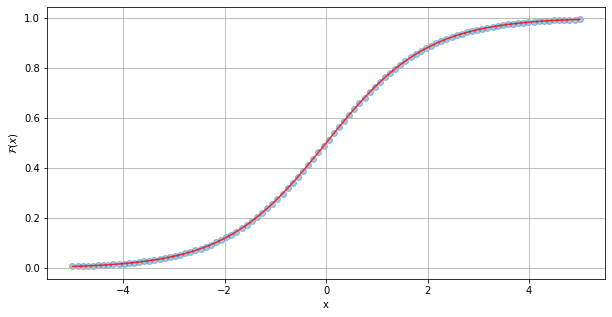

In [63]:
# plot the model as a scatter plot and the true function as a line plot
x_plot = np.linspace(-5, 5, 100)
plt.figure(figsize=(10, 5))
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp( -x_plot )), color='r', alpha=0.8)
plt.xlabel('x')
plt.ylabel(r'$\mathcal{F}(x)$')
plt.grid()
plt.show()

In [64]:
# lets see that this model is deterministic
x = np.array([0])
x

array([0])

In [65]:
y_model = model(x)
y_model.numpy()

array([[0.5]], dtype=float32)

In [66]:
# predict 5 times with the same x
for _ in range(5):
    y_model = model(x)
    print(y_model.numpy())

# which gives the same output value

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


In [67]:
# lets instead a probabilistic model using the tensorflow probability layers using the Bernoulli distribution

model_prob = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
                                kernel_initializer=tf.constant_initializer(1),
                                bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)
                            ]
    
)

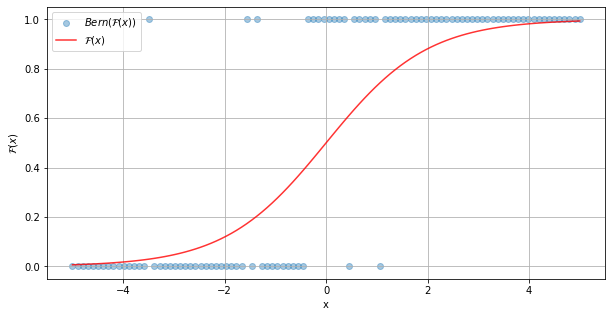

In [70]:
# lets plot this model
x_plot = np.linspace(-5, 5, 100)
plt.figure(figsize=(10, 5))
plt.scatter(x_plot, model_prob.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp( -x_plot )), color='r', alpha=0.8)
plt.legend([r'$Bern(\mathcal{F}(x))$', r'$\mathcal{F}(x)$'])
plt.xlabel('x')
plt.ylabel(r'$\mathcal{F}(x)$')
plt.grid()
plt.show()

In [71]:
# lets see if this model is deterministic
x = np.array([0])
x

array([0])

In [73]:
y_prob_mod = model_prob(x)
y_prob_mod

<tfp.distributions._TensorCoercible 'sequential_3_distribution_lambda_4_tensor_coercible' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [75]:
for _ in range(5):
    print(model_prob.predict(x))

# which gives a different value based on the probability distribution

[[0]]
[[1]]
[[1]]
[[0]]
[[0]]


In [150]:
# lets do some trainng, by first defining an untrained model
model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(0.7),
    bias_initializer=tf.constant_initializer(0.3)),
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t), 
    convert_to_tensor_fn=tfd.Distribution.sample)
])

# tfpl.DistributionLambda( lambda function -> some distribution to sample from )


In [151]:
# training with negative log likelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [152]:
model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))

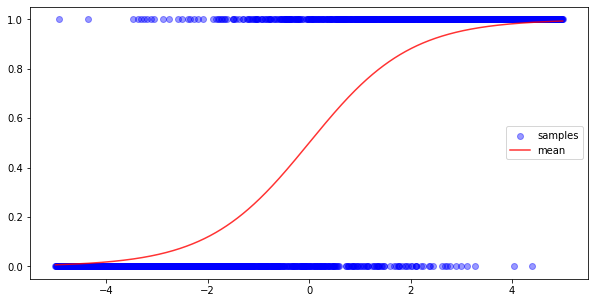

In [153]:
# lets create some training data
x_train = np.linspace(-5 ,5, 1500)[:, np.newaxis]
y_train = model_prob.predict(x_train)

# plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x_train, y_train, alpha=0.4, color='blue', label='samples')
ax.plot(x_train, model_prob(x_train).mean().numpy().flatten(), color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()



In [154]:
epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]

for epoch in tqdm(range(1000)):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

100%|██████████| 1000/1000 [00:27<00:00, 36.55it/s]


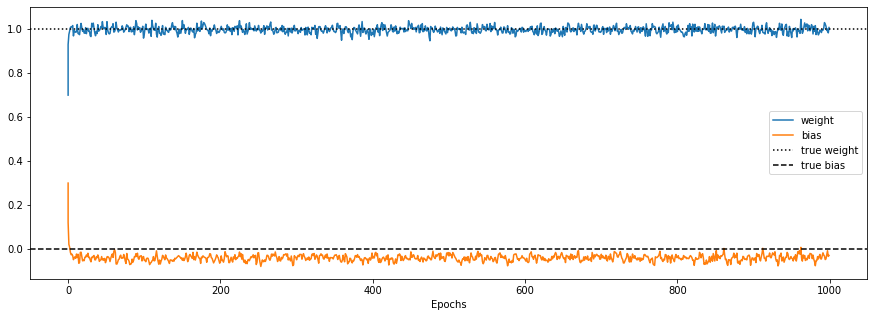

In [155]:
plt.figure(figsize=(15,5))
plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true weight', color='k', linestyle=':')
plt.axhline(y=0, label='true bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()
